# **HW 4 - Model Attack**



In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 8

In [22]:
cifar_10_mean = (0.491, 0.482, 0.447)
cifar_10_std = (0.202, 0.199, 0.201)

mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 32/255/std

root = '/content/drive/MyDrive/AI/data'

## Data


In [23]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])

class AdvDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.transform = transform
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label
    def __getname__(self):
        return self.names
    def __len__(self):
        return len(self.images)

adv_set = AdvDataset(root, transform=transform)
adv_names = adv_set.__getname__()
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

print(f'number of images = {adv_set.__len__()}')

number of images = 200


## Real Images Evaluation

In [24]:
def epoch_real(model, loader, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        yp = model(x)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)

# Example and Directory Generation Function

In [25]:
def gen_adv_examples(model, loader, attack, loss_fn, **attack_params):
    model.eval()
    adv_examples = []
    train_acc, train_loss = 0.0, 0.0

    for i, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)

        # 傳遞額外參數給攻擊方法
        x_adv = attack(model, x, y, loss_fn, **attack_params)

        # 調試代碼：檢查對抗樣本
        #print(f"x_adv: {type(x_adv)}, shape: {x_adv.shape if isinstance(x_adv, torch.Tensor) else 'N/A'}")

        # 使用模型對對抗樣本進行預測
        yp = model(x_adv)

        # 調試代碼：檢查模型輸出和目標類型
        #print(f"Model output: {type(yp)}, shape: {yp.shape if isinstance(yp, torch.Tensor) else 'N/A'}")
        #print(f"Target: {type(y)}, shape: {y.shape if isinstance(y, torch.Tensor) else 'N/A'}")

        # 計算損失
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        train_loss += loss.item() * x.shape[0]

        # 存儲對抗樣本
        adv_ex = ((x_adv) * std + mean).clamp(0, 1)
        adv_ex = (adv_ex * 255).clamp(0, 255)
        adv_ex = adv_ex.detach().cpu().data.numpy().round()
        adv_ex = adv_ex.transpose((0, 2, 3, 1))
        adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]

    return adv_examples, train_acc / len(loader.dataset), train_loss / len(loader.dataset)


In [26]:
# create directory which stores adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, adv_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, adv_names):
        im = Image.fromarray(example.astype(np.uint8))
        im.save(os.path.join(adv_dir, name))

## Attack Algorithm

In [27]:
def fgsm(model, x, y, loss_fn, epsilon=epsilon):
    x_adv = x.clone().detach()  # 確保不會改動原始輸入數據
    x_adv.requires_grad = True  # 開啟梯度計算

    # 前向傳播，計算損失
    outputs = model(x_adv)
    loss = loss_fn(outputs, y)

    # 反向傳播，計算輸入數據的梯度
    model.zero_grad()
    loss.backward()

    # 使用梯度的符號生成對抗樣本
    x_adv = x_adv + epsilon * x_adv.grad.sign()

    # 確保對抗樣本仍然在合法範圍內
    x_adv = torch.clamp(x_adv, 0, 1)

    return x_adv

def ifgsm(model, x, y, loss_fn, alpha, epsilon, num_iter):
    x_adv = x.clone().detach()  # 確保不會改動原始輸入數據

    for _ in range(num_iter):
        x_adv.requires_grad = True  # 確保啟用梯度計算

        # 前向傳播，計算損失
        outputs = model(x_adv)
        loss = loss_fn(outputs, y)

        # 反向傳播，計算輸入數據的梯度
        model.zero_grad()
        loss.backward()

        # 使用梯度的符號更新對抗樣本
        x_adv = x_adv + alpha * x_adv.grad.sign()

        # 確保對抗樣本仍然在合法範圍內
        x_adv = torch.clamp(x_adv, x - epsilon, x + epsilon)
        x_adv = torch.clamp(x_adv, 0, 1)

        # 重新克隆為 leaf 節點
        x_adv = x_adv.detach()

    return x_adv


def mifgsm(model, x, y, loss_fn, epsilon, alpha, num_iter, decay):
    x_adv = x.clone().detach()  # 確保不會改動原始輸入數據
    momentum = torch.zeros_like(x).detach()  # 初始化動量

    for _ in range(num_iter):
        # 每次迭代前，確保 x_adv 是 leaf 節點
        x_adv.requires_grad = True

        # 前向傳播，計算損失
        outputs = model(x_adv)
        loss = loss_fn(outputs, y)

        # 反向傳播，計算輸入數據的梯度
        model.zero_grad()
        loss.backward()

        # 更新動量
        grad = x_adv.grad.data
        momentum = decay * momentum + grad / grad.norm(p=1)

        # 使用動量更新對抗樣本
        x_adv = x_adv + alpha * momentum.sign()

        # 確保對抗樣本仍然在合法範圍內
        x_adv = torch.clamp(x_adv, x - epsilon, x + epsilon)
        x_adv = torch.clamp(x_adv, 0, 1)

        # 重新克隆為 leaf 節點，清除梯度圖
        x_adv = x_adv.detach()

    return x_adv



## Model / Loss Function



In [28]:
!pip install pytorchcv

In [29]:
from pytorchcv.model_provider import get_model as ptcv_get_model

model = ptcv_get_model('resnet110_cifar10', pretrained=True).to(device)
loss_fn = nn.CrossEntropyLoss()

real_acc, real_loss = epoch_real(model, adv_loader, loss_fn)
print(f'real_acc = {real_acc:.5f}, real_loss = {real_loss:.5f}')

real_acc = 0.95000, real_loss = 0.22678


## FGSM

In [30]:
adv_examples, fgsm_acc, fgsm_loss = gen_adv_examples(model, adv_loader, fgsm, loss_fn)
print(f'fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')

create_dir(root, '/content/drive/MyDrive/AI/fgsm', adv_examples, adv_names)

fgsm_acc = 0.21500, fgsm_loss = 4.18207


## I-FGSM

In [31]:
# 設置 ifgsm 的參數
alpha = 0.01
epsilon = 0.1
num_iter = 10

# 調用 gen_adv_examples 並傳遞參數
adv_examples, ifgsm_acc, ifgsm_loss = gen_adv_examples(
    model, adv_loader, ifgsm, loss_fn, alpha=alpha, epsilon=epsilon, num_iter=num_iter
)

print(f'ifgsm_acc = {ifgsm_acc:.5f}, ifgsm_loss = {ifgsm_loss:.5f}')

create_dir(root, '/content/drive/MyDrive/AI/ifgsm', adv_examples, adv_names)


ifgsm_acc = 0.08500, ifgsm_loss = 9.15678


## MI-FGSM

In [32]:
# 設置 mifgsm 的參數
alpha = 0.01
epsilon = 0.1
num_iter = 10
decay = 1.0

adv_examples, mifgsm_acc, mifgsm_loss = gen_adv_examples(
    model, adv_loader, mifgsm, loss_fn, alpha=alpha, epsilon=epsilon, num_iter=num_iter, decay=decay
)

print(f'mifgsm_acc = {mifgsm_acc:.5f}, mifgsm_loss = {mifgsm_loss:.5f}')

create_dir(root, '/content/drive/MyDrive/AI/mifgsm', adv_examples, adv_names)


mifgsm_acc = 0.19500, mifgsm_loss = 7.46102


## Ensemble Attack

In [33]:
class ensembleNet(nn.Module):
    def __init__(self, model_names):
        super().__init__()
        self.models = nn.ModuleList([ptcv_get_model(name, pretrained=True) for name in model_names])

    def forward(self, x):
        # 聚合每個模型的 logits
        ensemble_logits = torch.zeros_like(self.models[0](x))
        for m in self.models:
            ensemble_logits += m(x)
        # 返回聚合的 logits
        return ensemble_logits / len(self.models)


In [34]:
model_names = [
    'nin_cifar10',
    'resnet20_cifar10',
    'preresnet20_cifar10'
]
ensemble_model = ensembleNet(model_names).to(device)
ensemble_model.eval()


ensembleNet(
  (models): ModuleList(
    (0): CIFARNIN(
      (features): Sequential(
        (stage1): Sequential(
          (unit1): NINConv(
            (conv): Conv2d(3, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (activ): ReLU(inplace=True)
          )
          (unit2): NINConv(
            (conv): Conv2d(192, 160, kernel_size=(1, 1), stride=(1, 1))
            (activ): ReLU(inplace=True)
          )
          (unit3): NINConv(
            (conv): Conv2d(160, 96, kernel_size=(1, 1), stride=(1, 1))
            (activ): ReLU(inplace=True)
          )
        )
        (stage2): Sequential(
          (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (dropout2): Dropout(p=0.5, inplace=False)
          (unit1): NINConv(
            (conv): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (activ): ReLU(inplace=True)
          )
          (unit2): NINConv(
            (conv): Conv2d(192, 19

In [35]:
# 設置 ifgsm 的參數
alpha = 0.01
epsilon = 0.1
num_iter = 10

# 調用 gen_adv_examples，檢查 ensemble_model 和 ifgsm 是否正確交互
adv_examples, ensemble_acc, ensemble_loss = gen_adv_examples(
    ensemble_model, adv_loader, ifgsm, loss_fn, alpha=alpha, epsilon=epsilon, num_iter=num_iter
)

print(f'ensemble_acc = {ensemble_acc:.5f}, ensemble_loss = {ensemble_loss:.5f}')
create_dir(root, '/content/drive/MyDrive/AI/ensemble', adv_examples, adv_names)


ensemble_acc = 0.04000, ensemble_loss = 6.24745


## Visualization

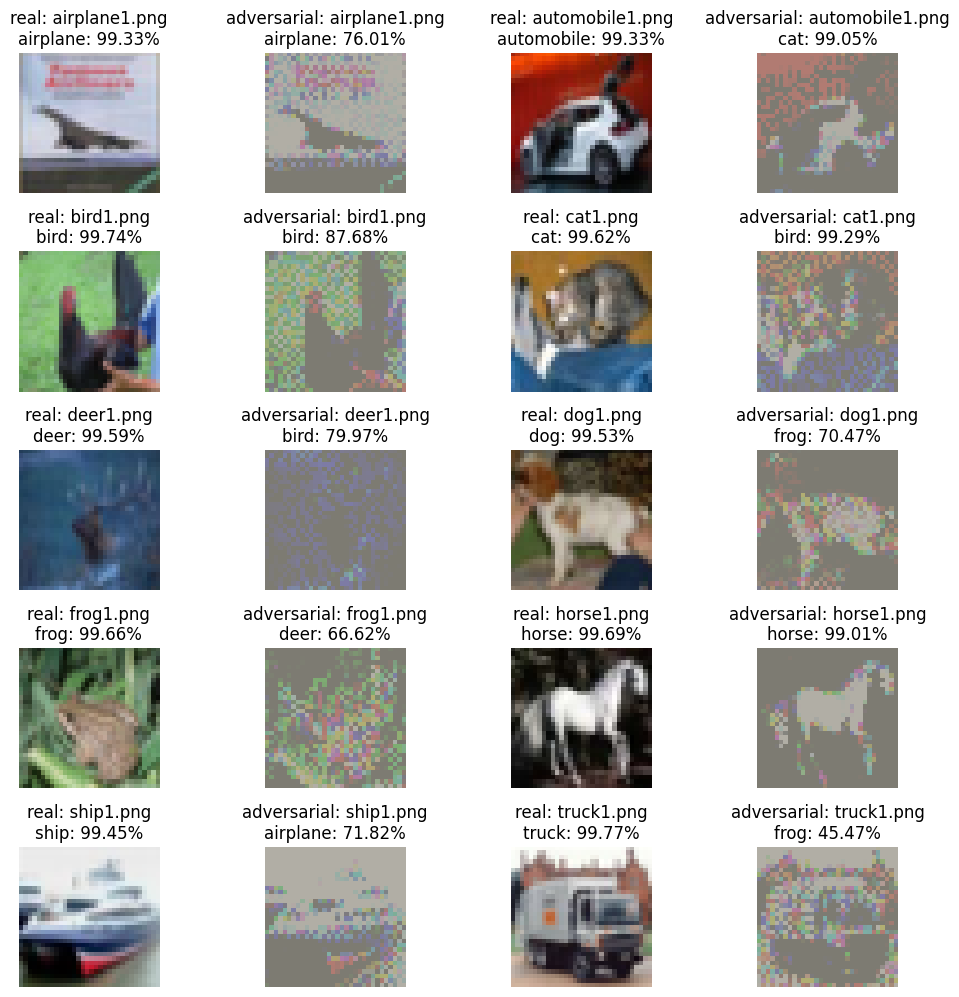

In [39]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}1.png'
    # real image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'/content/drive/MyDrive/AI/data/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'real: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'/content/drive/MyDrive/AI/fgsm/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/AI/result.png")
plt.show()